<a href="https://colab.research.google.com/github/rikudoayush/Attention_from_scratch/blob/main/SEQ_to_SQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas
import spacy
from spacy.lang.en import English
from spacy.lang.fr import French
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm_notebook
import random
from collections import Counter

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [18]:
# Reading the English-French sentences pairs from the file
with open("/content/drive/MyDrive/Untitled folder/fra.txt","r+") as file:
  fra = [x[:-1] for x in file.readlines()]
english = []
french = []
for i in range(len(fra)):
  english.append(fra[i].split("\t")[0])
  french.append(fra[i].split("\t")[1])

#Setting the number of training sentences we'll use
training_examples = 10000
#We'll be using the spaCy's English and German tokenizers
spacy_en = English()
spacy_fra = French()

en_words = Counter()
fra_words = Counter()
en_inputs = []
fra_inputs = []

#Tokenizing the English and French sentences and creating our word banks for both languages
for i in tqdm_notebook(range(training_examples)):
    en_tokens = spacy_en(english[i])
    fra_tokens = spacy_fra(french[i])
    if len(en_tokens)==0 or len(fra_tokens)==0:
        continue
    for token in en_tokens:
        en_words.update([token.text.lower()])
    en_inputs.append([token.text.lower() for token in en_tokens] + ['_EOS'])
    for token in fra_tokens:
        fra_words.update([token.text.lower()])
    fra_inputs.append([token.text.lower() for token in fra_tokens] + ['_EOS'])

#Assigning an index to each word token, including the Start Of String(SOS), End Of String(EOS) and Unknown(UNK) tokens
en_words = ['_SOS','_EOS','_UNK'] + sorted(en_words,key=en_words.get,reverse=True)
en_w2i = {o:i for i,o in enumerate(en_words)}
en_i2w = {i:o for i,o in enumerate(en_words)}
fra_words = ['_SOS','_EOS','_UNK'] + sorted(fra_words,key=fra_words.get,reverse=True)
fra_w2i = {o:i for i,o in enumerate(fra_words)}
fra_i2w = {i:o for i,o in enumerate(fra_words)}

#Converting our English and German sentences to their token indexes
for i in range(len(en_inputs)):
    en_sentence = en_inputs[i]
    fra_sentence = fra_inputs[i]
    en_inputs[i] = [en_w2i[word] for word in en_sentence]
    fra_inputs[i] = [fra_w2i[word] for word in fra_sentence]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


# ENCODER

In [19]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, drop_prob=0):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=drop_prob, batch_first=True)

    def forward(self, inputs, hidden):
        #Embed input words
        embedded = self.embedding(inputs)
        #Pass the embedded word vectors into LSTM and return all outputs
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

# BahdanauDecoder

In [20]:
class BahdanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
        super(BahdanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size*2, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        encoder_outputs = encoder_outputs.squeeze()
        #Embed input words
        embedded = self.embedding(inputs).view(1, -1)
        embedded = self.dropout(embedded)

        #Calculating Alignment Scores
        x = torch.tanh(self.fc_hidden(hidden[0])+self.fc_encoder(encoder_outputs))
        alignment_scores = x.bmm(self.weight.unsqueeze(2))  

        #Softmaxing alignment scores to get Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        #Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        #Concatenating context vector with embedded input word
        output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        #Passing the concatenated vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)
        #Passing the LSTM output through a Linear layer acting as a classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights

# LuongDecoder

In [21]:
class LuongDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
        super(LuongDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        #Our Attention Mechanism is defined in a separate class
        self.attention = attention

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.classifier = nn.Linear(self.hidden_size*2, self.output_size)
    
    def forward(self, inputs, hidden, encoder_outputs):
        #Embed input words
        embedded = self.embedding(inputs).view(1,1,-1)
        embedded = self.dropout(embedded)

        #Passing previous output word (embedded) and hidden state into LSTM cell
        lstm_out, hidden = self.lstm(embedded, hidden)

        #Calculating Alignment Scores - see Attention class for the forward pass function
        alignment_scores = self.attention(hidden[0], encoder_outputs)
        #Softmaxing alignment scores to obtain Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        #Multiplying Attention weights with encoder outputs to get context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs)

        #Concatenating output from LSTM with context vector
        output = torch.cat((lstm_out, context_vector),-1)
        #Pass concatenated vector through Linear layer acting as a Classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights

class Attention(nn.Module):
    def __init__(self, hidden_size, method="dot"):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        #Defining the layers/weights required depending on alignment scoring method
        if method == "general":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)

        elif method == "concat":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)
            self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
  
    def forward(self, decoder_hidden, encoder_outputs):
        if self.method == "dot":
          #For the dot scoring method, no weights or linear layers are involved
          return encoder_outputs.bmm(decoder_hidden.view(1,-1,1)).squeeze(-1)
    
        elif self.method == "general":
            #For general scoring, decoder hidden state is passed through linear layers to introduce a weight matrix
            out = self.fc(decoder_hidden)
            return encoder_outputs.bmm(out.view(1,-1,1)).squeeze(-1)

        elif self.method == "concat":
            #For concat scoring, decoder hidden state and encoder outputs are concatenated first
            out = torch.tanh(self.fc(decoder_hidden+encoder_outputs))
            return out.bmm(self.weight.unsqueeze(-1)).squeeze(-1)

In [22]:
hidden_size = 256
encoder = EncoderLSTM(len(en_words), hidden_size).to(device)
attn = Attention(hidden_size,"concat")
decoder = LuongDecoder(hidden_size,len(fra_words),attn).to(device)

lr = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

In [23]:
EPOCHS = 10
teacher_forcing_prob = 0.5
encoder.train()
decoder.train()
tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)
for epoch in tk0:
    avg_loss = 0.
    tk1 = tqdm_notebook(enumerate(en_inputs),total=len(en_inputs),leave=False)
    for i, sentence in tk1:
        loss = 0.
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        inp = torch.tensor(sentence).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)
        
        #First decoder input will be the SOS token
        decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
        #First decoder hidden state will be last encoder hidden state
        decoder_hidden = h
        output = []
        teacher_forcing = True if random.random() < teacher_forcing_prob else False
        
        for ii in range(len(fra_inputs[i])):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #Get the index value of the word with the highest score from the decoder output
            top_value, top_index = decoder_output.topk(1)
            if teacher_forcing:
                decoder_input = torch.tensor([fra_inputs[i][ii]],device=device)
            else:
                decoder_input = torch.tensor([top_index.item()],device=device)
            output.append(top_index.item())
            #Calculate the loss of the prediction against the actual word
            loss += F.nll_loss(decoder_output.view(1,-1), torch.tensor([fra_inputs[i][ii]],device=device))
        loss = loss/len(fra_inputs[i])
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        avg_loss += loss.item()/len(en_inputs)
    tk0.set_postfix(loss=avg_loss)
    #Save model after every epoch (Optional)
    torch.save({"encoder":encoder.state_dict(),"decoder":decoder.state_dict(),"e_optimizer":encoder_optimizer.state_dict(),"d_optimizer":decoder_optimizer},"/content/drive/MyDrive/Untitled folder/model.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


English: be creative . _EOS
Predicted: sois créatifs !
Actual: sois créative ! _EOS


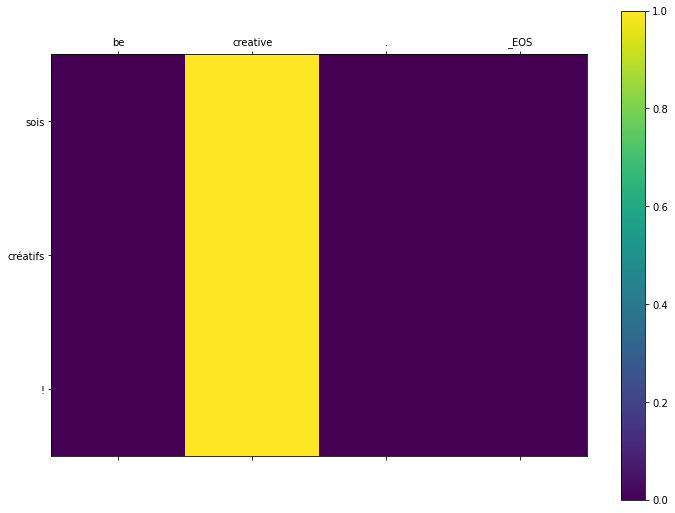

In [25]:
encoder.eval()
decoder.eval()
#Choose a random sentences
i = random.randint(0,len(en_inputs)-1)
h = encoder.init_hidden()
inp = torch.tensor(en_inputs[i]).unsqueeze(0).to(device)
encoder_outputs, h = encoder(inp,h)

decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
decoder_hidden = h
output = []
attentions = []
while True:
    decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
    _, top_index = decoder_output.topk(1)
    decoder_input = torch.tensor([top_index.item()],device=device)
    #If the decoder output is the End Of Sentence token, stop decoding process
    if top_index.item() == fra_w2i["_EOS"]:
        break
    output.append(top_index.item())
    attentions.append(attn_weights.squeeze().cpu().detach().numpy())
print("English: "+ " ".join([en_i2w[x] for x in en_inputs[i]]))
print("Predicted: " + " ".join([fra_i2w[x] for x in output]))
print("Actual: " + " ".join([fra_i2w[x] for x in fra_inputs[i]]))

#Plotting the heatmap for the Attention weights
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(attentions))
fig.colorbar(cax)
ax.set_xticklabels(['']+[en_i2w[x] for x in en_inputs[i]])
ax.set_yticklabels(['']+[fra_i2w[x] for x in output])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

From the example above, we can see that for each output word from the decoder, the weights assigned to the input words are different and we can see the relationship between the inputs and outputs that the model is able to draw. You can try this on a few more examples to test the results of the translator.

In our training, we have clearly overfitted our model to the training sentences. If we were to test the trained model on sentences it has never seen before, it is unlikely to produce decent results. Nevertheless this process acts as a sanity check to ensure that our model works and is able to function end-to-end and learn.

The challenge of training an effective model can be attributed largely to the lack of training data and training time. Due to the complex nature of the different languages involved and large number of vocabulary and grammatical permutations, an effective model will require tons of data and training time before any results can be seen on evaluation data.